<p align = "center"><strong>LOCAL SPATIAL AUTOCORRELATION: MORAN’S I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Local Moran's Index__

__Def.__  

Medida **Local de autocorrelación espacial** que cuantifica el grado en que el valor de una variable en una unidad espacial está asociado con los valores de las unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.

El índice toma valores :
- $\to$ __positivo__ cuando existe asociación espacial positiva (valores similares)

- $\approx$ __0__ cuando NO hay autocorrelación espacial local

- $\to$ __negativo__ cuando existe asociación espacial negativa (valores disímiles)

__Formula:__

Desviaciones respecto la media
$$
z_i = x_i - \bar{x} \qquad z_j = x_j - \bar{x}
\qquad \bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_i
$$ 

Índice de Moran Local
$$
I_i =
z_i \sum_{j=1}^{n} w_{ij} z_j
$$

<p align = 'center'> 
<em>El índice de Moran Local permite identificar clústeres espaciales y valores atípicos espaciales, descomponiendo la autocorrelación espacial global en contribuciones individuales.</em>
</p>


donde : 
- $w_{ij}$ elemento de la matrix de pesos espaciales $W$
- $x_i$ valor observado de la variable de interés en la unidad espacial $i$.
- $x_j$ valor observado de la variable de interés en la unidad espacial contigua (vecina de $x_i$)
- $n$ número de unidades espaciales.
- $z_i$ valor centrado (no normalizado) de la observación $i$.


__Reference:__
- Anselin, L. (1995). *Local Indicators of Spatial Association—LISA*. Geographical Analysis, 27(2), 93–115.  
  https://doi.org/10.1111/j.1538-4632.1995.tb00338.x


In [ ]:
# DEPENDENCIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

    # Import data (shp)
import geopandas as gpd
    # Weight Matrix
from libpysal.weights import Queen, Rook, W, lag_spatial
    # Global index (MORAN'S)
from esda.moran import Moran, Moran_Local
    # Warnings
import warnings

def local_moran(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_x: bool = True,
    use_index: bool = True,
    figsize=(18, 12),
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_field: str | None = None,
):
    """
    Local Moran (LISA) for MULTIPLE variables and 3 contiguities (Queen/Rook/Bishop).

    Returns:
      - results_table: long table with Global Moran + LISA counts (per variable x contiguity)
      - fig: Dashboard for ONE variable (dashboard_field):
             (1) Moran scatter, (2) LISA significance map, (3) LISA cluster map
             repeated for each contiguity (rows)
      - out: dict with detailed objects for the dashboard_field

    Assumption:
      - gdf is already clean (numeric, no NaN/inf). If not, you can re-enable a numeric mask.
    """

    # BASIC INPUT HANDLING
    if isinstance(fields, str):
        fields = [fields]
    fields = list(fields)

    missing = [c for c in fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # Default dashboard variable (the one that will be plotted)
    if dashboard_field is None:
        dashboard_field = fields[0]
    if dashboard_field not in fields:
        raise ValueError("dashboard_field must be inside fields")

    # Important note about islands alignment
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )

    # PLOT STYLE AND WARNING HANDLING 
    plt.style.use(style)

    if silence_warnings:
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=".*weights matrix is not fully connected.*",
        )
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            message=".*use_index.*",
        )

    # HELPER: BUILD SPATIAL WEIGHTS
    def build_w(df, kind):
        """
        Build a spatial weights object for a given contiguity type:
          - queen  : shared edge OR vertex
          - rook   : shared edge
          - bishop : shared vertex only (queen minus rook)
        """
        if kind == "queen":
            return Queen.from_dataframe(df, use_index=use_index)

        if kind == "rook":
            return Rook.from_dataframe(df, use_index=use_index)

        if kind == "bishop":
            wq = Queen.from_dataframe(df, use_index=use_index)
            wr = Rook.from_dataframe(df, use_index=use_index)

            ids = list(wq.id_order)
            neighbors = {}
            for i in ids:
                nq = set(wq.neighbors.get(i, []))
                nr = set(wr.neighbors.get(i, []))
                neighbors[i] = list(nq - nr)  # vertex-only adjacency

            return W(neighbors, id_order=ids)

        raise ValueError("kind must be queen/rook/bishop")

    # HELPER: Z-SCORE STANDARIZATION FOR MORAN SCATTERPLOT
    def zscore(x):
        sd = x.std(ddof=0)
        return (x - x.mean()) / sd if sd > 0 else x * 0.0

    # PRECOMPUTE (BY CONTIGUITY) :  WEIGHTS + ISLAND HANDLING ONCE
    kinds = list(contiguities)
    by_kind = {}

    for kind in kinds:
        df2 = gdf.copy()

        # Build weights on the full GeoDataFrame
        w = build_w(df2, kind)
        islands_initial = list(getattr(w, "islands", []))

        # Optionally drop islands and rebuild weights
        if drop_islands and len(islands_initial) > 0:
            df2 = df2.drop(index=islands_initial).copy() if use_index else df2.copy()
            w = build_w(df2, kind)

        # Row-standardize weights (GeoDa convention)
        w.transform = "R"

        by_kind[kind] = {
            "gdf": df2,
            "w": w,
            "islands_initial": islands_initial,
        }

    # RESULTS TABLE 
    rows = []

    for field in fields:
        for kind in kinds:
            df2 = by_kind[kind]["gdf"]
            w = by_kind[kind]["w"]
            islands_initial = by_kind[kind]["islands_initial"]

            # Extract the variable values (assumed already numeric/clean)
            x = df2[field].to_numpy()

            # Degenerate cases: too few observations or zero variance
            if len(x) < 3 or np.std(x, ddof=0) == 0:
                rows.append({
                    "variable": field,
                    "contiguity": kind.upper(),
                    "n": int(len(x)),
                    "global_I": np.nan,
                    "global_p_perm": np.nan,
                    "permutations": int(permutations),
                    "alpha": float(alpha),
                    "islands_initial": int(len(islands_initial)),
                    "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                    "islands_remaining": int(len(getattr(w, "islands", []))),
                    "sig_0_not": np.nan,
                    "sig_1_p05": np.nan,
                    "sig_2_p01": np.nan,
                    "sig_3_p001": np.nan,
                    "HH": np.nan,
                    "LL": np.nan,
                    "LH": np.nan,
                    "HL": np.nan,
                    "note": "n<3 or zero variance",
                })
                continue

            # Global Moran (for reporting)
            mi = Moran(x, w, permutations=permutations)

            # Local Moran (LISA)
            lisa = Moran_Local(x, w, permutations=permutations)
            p = lisa.p_sim

            # Significance classes: 
                # 0 = Not significant, 1 = p <= 0.05), 2 = p <= 0.01, 3 = p <= 0.001
            sig_class = np.zeros_like(p, dtype=int)
            sig_class[(p <= 0.05) & (p > 0.01)] = 1
            sig_class[(p <= 0.01) & (p > 0.001)] = 2
            sig_class[p <= 0.001] = 3

            sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)

            # Cluster classes based on lisa.q (only if significant at alpha):
            # lisa.q codes: 1=HH, 2=LH, 3=LL, 4=HL
            cl_class = np.zeros_like(p, dtype=int)
            sig_alpha = p <= alpha
            q = lisa.q

            cl_class[sig_alpha & (q == 1)] = 1  # HH
            cl_class[sig_alpha & (q == 3)] = 2  # LL
            cl_class[sig_alpha & (q == 2)] = 3  # LH (Low-High)
            cl_class[sig_alpha & (q == 4)] = 4  # HL (High-Low)

            cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

            rows.append({
                "variable": field,
                "contiguity": kind.upper(),
                "n": int(len(x)),
                "global_I": float(mi.I),
                "global_p_perm": float(mi.p_sim),
                "permutations": int(permutations),
                "alpha": float(alpha),
                "islands_initial": int(len(islands_initial)),
                "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                "islands_remaining": int(len(getattr(w, "islands", []))),
                "sig_0_not": int(sig_counts[0]),
                "sig_1_p05": int(sig_counts[1]),
                "sig_2_p01": int(sig_counts[2]),
                "sig_3_p001": int(sig_counts[3]),
                "HH": int(cl_counts[1]),
                "LL": int(cl_counts[2]),
                "LH": int(cl_counts[3]),
                "HL": int(cl_counts[4]),
                "note": "",
            })

    results_table = pd.DataFrame(rows)

    # Force contiguity ordering
    order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
    results_table["contiguity"] = results_table["contiguity"].astype(str).str.upper().astype(order)
    results_table = results_table.sort_values(["variable", "contiguity"]).reset_index(drop=True)

    # DASHBOARD
    # GeoDa-like palettes + legends
    sig_labels = ["Not Significant", "p ≤ 0.05", "p ≤ 0.01", "p ≤ 0.001"]
    sig_colors = ["#f0f0f0", "#a1d99b","#41ab5d", "#005a32"]
    sig_cmap = ListedColormap(sig_colors)

    cl_labels = ["Not Significant", "High-High", "Low-Low", "Low-High", "High-Low"]
    cl_colors = ["#f0f0f0", "#e41a1c", "#377eb8", "#a6cee3", "#fb9a99"]
    cl_cmap = ListedColormap(cl_colors)

    out = {"dashboard_field": dashboard_field, "by_contiguity": {}}

    # Figure: rows = contiguities, cols = (scatter, significance, cluster)
    fig, axes = plt.subplots(len(kinds), 3, figsize=figsize)
    if len(kinds) == 1:
        axes = np.array([axes])

    for r, kind in enumerate(kinds):
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]

        x = df2[dashboard_field].to_numpy()

        # Global + Local Moran for plotting
        mi = Moran(x, w, permutations=permutations)
        lisa = Moran_Local(x, w, permutations=permutations)

            # Moran scatterplot 
        x_plot = zscore(x) if standardize_x else x.copy()
        wx_plot = lag_spatial(w, x_plot)

        ax_sc = axes[r, 0]
        ax_sc.scatter(x_plot, wx_plot, edgecolor="k", facecolor="none", s=25)
        ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)

        xx = np.linspace(np.min(x_plot), np.max(x_plot), 200)
        ax_sc.plot(xx, mi.I * xx, linewidth=2)

        ax_sc.set_title(f"{kind.upper()} — Moran Scatter (Global I={mi.I:.3f}, p={mi.p_sim:.4f})",fontweight = 'bold')
        ax_sc.set_xlabel(f"{dashboard_field} ({'std' if standardize_x else 'raw'})")
        ax_sc.set_ylabel("Spatial lag")

            # LISA classes 
        p = lisa.p_sim

        sig_class = np.zeros_like(p, dtype=int)
        sig_class[(p <= 0.05) & (p > 0.01)] = 1
        sig_class[(p <= 0.01) & (p > 0.001)] = 2
        sig_class[p <= 0.001] = 3

        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)

        cl_class = np.zeros_like(p, dtype=int)
        sig_alpha = p <= alpha
        q = lisa.q

        cl_class[sig_alpha & (q == 1)] = 1  # HH
        cl_class[sig_alpha & (q == 3)] = 2  # LL
        cl_class[sig_alpha & (q == 2)] = 3  # LH
        cl_class[sig_alpha & (q == 4)] = 4  # HL

        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

        gdf_plot = df2.copy()
        gdf_plot["_sig_class"] = sig_class
        gdf_plot["_cl_class"] = cl_class

        # Significance map
        ax_sig = axes[r, 1]
        gdf_plot.plot(
            column="_sig_class",
            categorical=True,
            cmap=sig_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_sig,
        )
        ax_sig.set_axis_off()
        ax_sig.set_title(f"{kind.upper()} — LISA Significance (perms={permutations})",fontweight = 'bold')

        sig_legend = [
            Patch(facecolor=sig_colors[i], edgecolor="k", label=f"{sig_labels[i]} ({int(sig_counts[i])})")
            for i in range(4)
        ]
        ax_sig.legend(handles=sig_legend, loc="lower left", frameon=True)

            # Cluster map
        ax_cl = axes[r, 2]
        gdf_plot.plot(
            column="_cl_class",
            categorical=True,
            cmap=cl_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_cl,
        )
        ax_cl.set_axis_off()
        ax_cl.set_title(f"{kind.upper()} — LISA Cluster (α={alpha})",fontweight = 'bold')

        cl_legend = [
            Patch(facecolor=cl_colors[i], edgecolor="k", label=f"{cl_labels[i]} ({int(cl_counts[i])})")
            for i in range(5)
        ]
        ax_cl.legend(handles=cl_legend, loc="lower left", frameon=True)

        # Store objects for downstream use
        out["by_contiguity"][kind] = {
            "gdf": gdf_plot,
            "w": w,
            "x": x,
            "mi_global": mi,
            "lisa": lisa,
            "x_plot": x_plot,
            "wx_plot": wx_plot,
            "islands_initial": islands_initial,
        }

    fig.suptitle(
        f"LISA MORAN — {dashboard_field}",
        y=1.02,
        fontsize=14,fontweight = 'bold'
    )
    fig.tight_layout()

    return results_table, fig, out

In [ ]:
# Import data 
gdf = gpd.read_file("../healthindicators/HealthIndicators.shp")

,variable,contiguity,n,global_I,global_p_perm,permutations,alpha,islands_initial,islands_removed,islands_remaining,sig_0_not,sig_1_p05,sig_2_p01,sig_3_p001,HH,LL,LH,HL,note
0,Below_evel,QUEEN,77,0.456615,0.001,999,0.05,0,0,0,52,16,8,1,10,11,3,1,
1,Below_evel,ROOK,77,0.465253,0.001,999,0.05,0,0,0,53,15,7,2,10,11,3,0,
2,Below_evel,BISHOP,31,0.284716,0.103,999,0.05,46,46,0,28,3,0,0,1,2,0,0,
3,BirthRate,QUEEN,77,0.321203,0.001,999,0.05,0,0,0,57,14,4,2,13,4,1,2,
4,BirthRate,ROOK,77,0.333674,0.001,999,0.05,0,0,0,57,14,4,2,13,4,0,3,
5,BirthRate,BISHOP,31,0.040896,0.375,999,0.05,46,46,0,27,3,0,1,1,2,1,0,
6,TeenB_Rate,QUEEN,77,0.538320,0.001,999,0.05,0,0,0,52,14,9,2,13,11,0,1,
7,TeenB_Rate,ROOK,77,0.549971,0.001,999,0.05,0,0,0,52,15,9,1,13,11,0,1,
8,TeenB_Rate,BISHOP,31,0.266631,0.115,999,0.05,46,46,0,29,1,0,1,0,0,1,1,
9,Unemp_ment,QUEEN,77,0.465670,0.001,999,0.05,0,0,0,49,17,8,3,11,15,2,0,


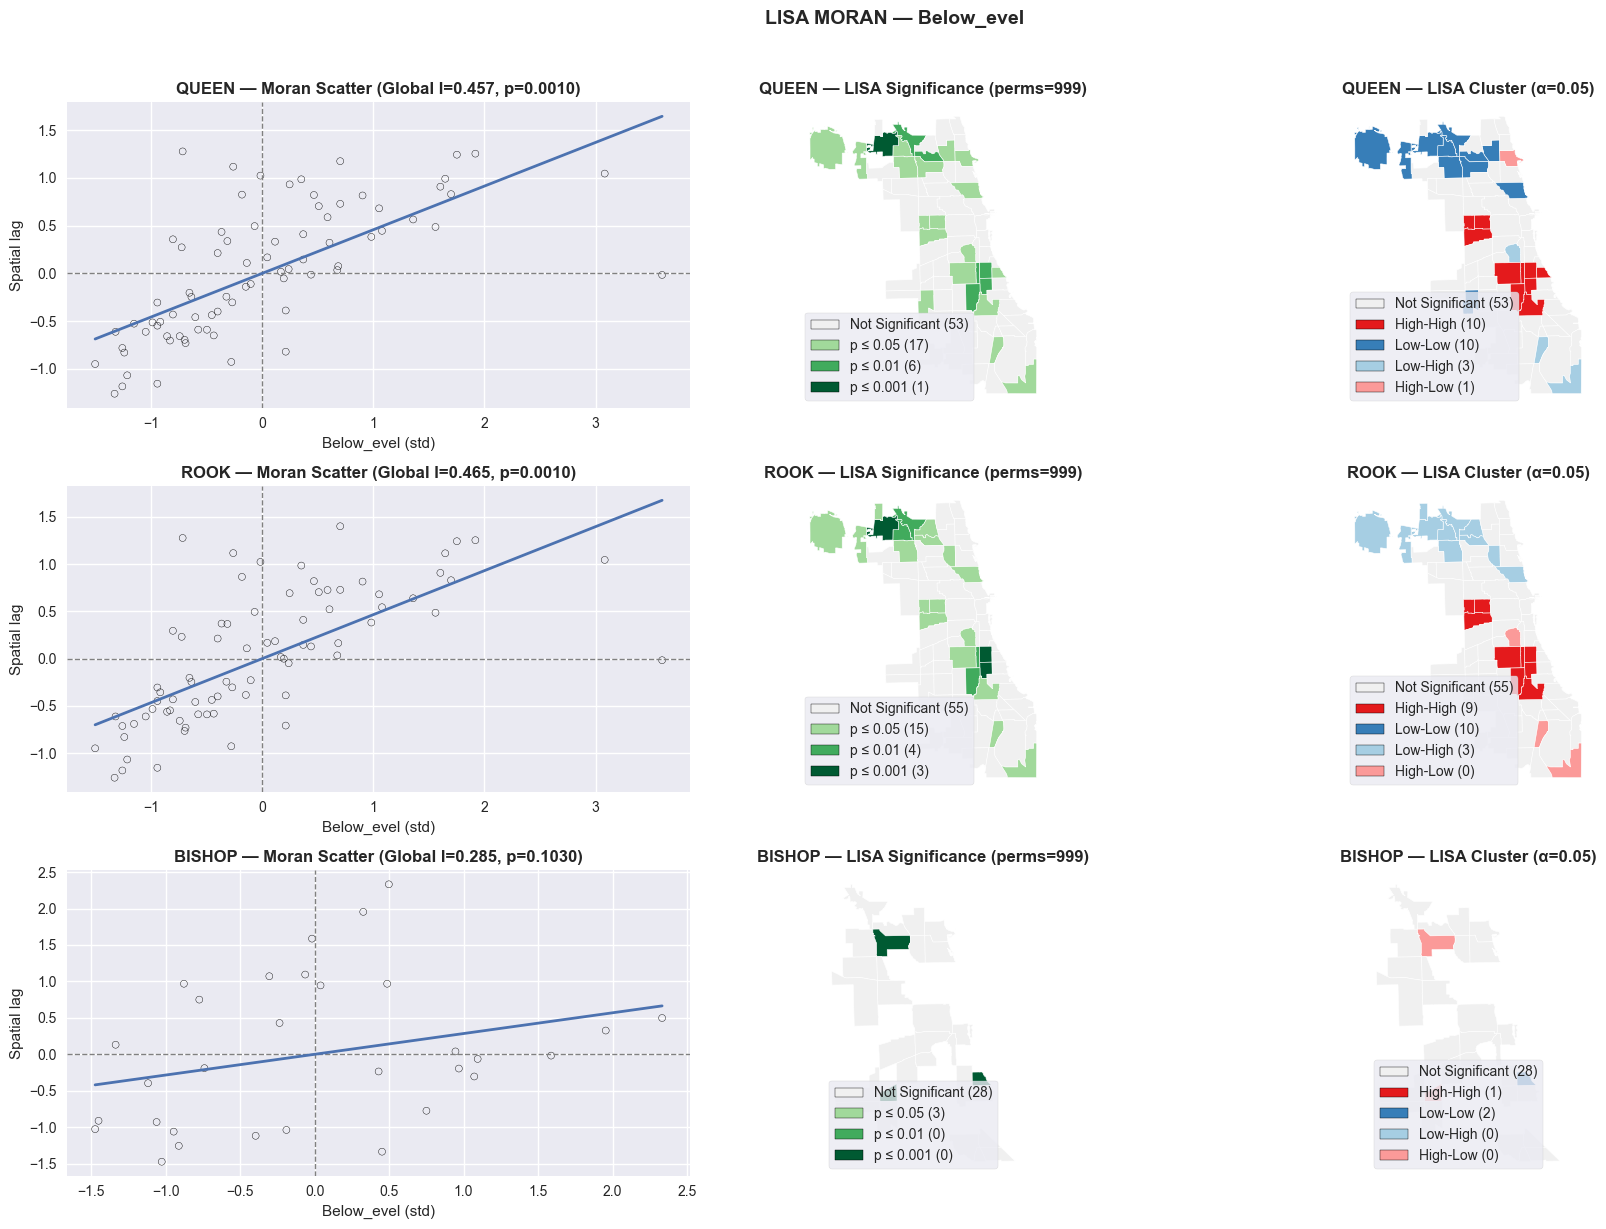

In [22]:
# Inputs 
fields = ["Unemp_ment", "Below_evel", "BirthRate", "TeenB_Rate"]

table, fig, out = local_moran(
    gdf,
    fields,
    permutations=999,
    alpha=0.05,
    dashboard_field="Below_evel",
)

# Outputs
display(table)
plt.show()

---